In [3]:
using Pkg
Pkg.instantiate()

In [22]:
using GraphPPL
using Rocket
using ReactiveMP
using Distributions
using Plots
using LinearAlgebra
using Random
using JLD
using FFTW
using Parameters
import ProgressMeter
using CSV
using DataFrames

In [23]:
import ReactiveMP.messageout

In [135]:
include("../helpers/nonlinear_node.jl")
include("../helpers/polynomial.jl");
include("../helpers/utils.jl");
include("../helpers/data.jl");

## Generate signal

In [136]:
# find order
seed = 42

delay_y, delay_u, delay_e = 3, 3, 3
order_h = delay_e + 1 # e_k, e_{k-1}, e_{k-2}
order_u = delay_u + 1 # u_k, u_{k-1}, u_{k-2}

poly_order = 2

options = Dict("na"=>delay_y, "nb"=>delay_u, "ne"=>delay_e, "nd"=>poly_order, "dc"=>false, "crossTerms"=>true, "noiseCrossTerms"=>false)
syn_input, syn_noise, syn_output, η_true = generate_data(seed, ϕ, options, scale_coef=0.2);

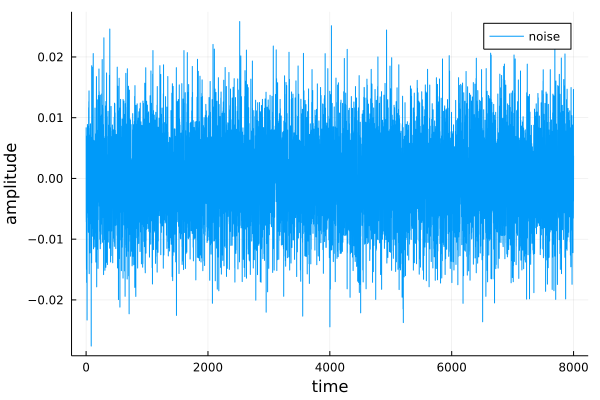

In [137]:
# Visualize noise
plot(syn_noise, xlabel="time", ylabel="amplitude", label="noise")

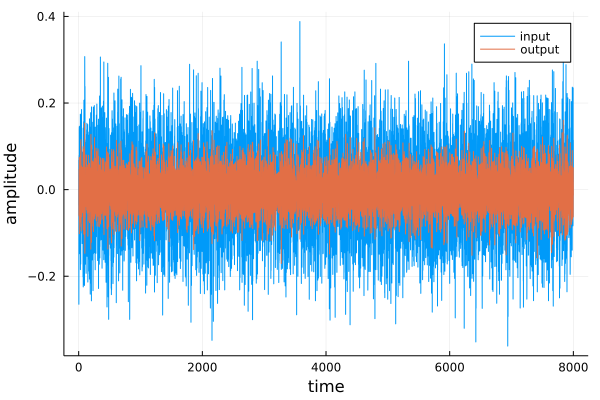

In [138]:
# Plot both input and outputs
plot(syn_input, label="input")
plot!(syn_output, xlabel="time", ylabel="amplitude", label="output")

In [139]:
train_size = 5000+order_u
test_size = 1000+order_u

u_train = syn_input[1:train_size]
u_val = syn_input[train_size + 1:train_size + test_size]
y_train = syn_output[1:train_size]
y_val = syn_output[train_size + 1:train_size + test_size]

# normalization
m_y, s_y = mean(y_train), std(y_train)
m_u, s_u = mean(u_train), std(u_train)
output_trn = (y_train .- m_y) ./ s_y
output_val = (y_val .- m_y) ./ s_y
input_trn = (u_train .- m_u) ./ s_u
input_val = (u_val .- m_u) ./ s_u;

# output_trn = y_train
# output_val = y_val
# input_trn = u_train
# input_val = u_val

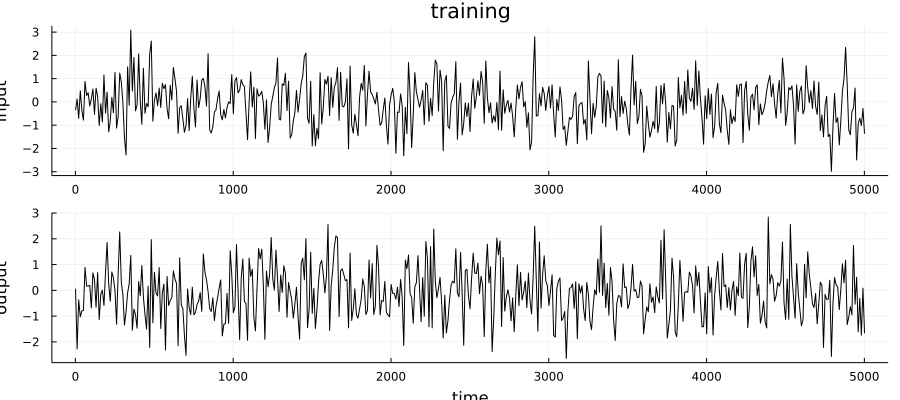

In [140]:
# Plot every n-th time-point to avoid figure size exploding
n = 10
ix = 1:n:length(output_trn)

# Plot training signals
p1a = plot(ix, input_trn[ix], color="black", label="", xlabel="", ylabel="input", title="training")    
p1b = plot(ix, output_trn[ix], color="black", label="", xlabel="time", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1))

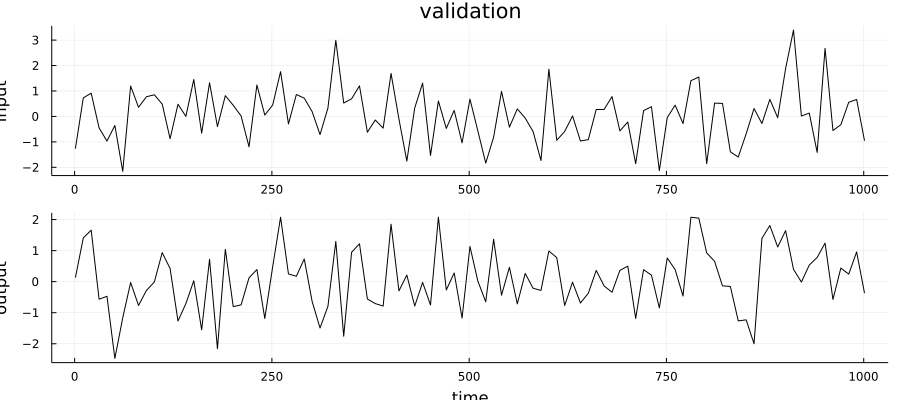

In [141]:
n = 10
ix = 1:n:length(output_val)

# Plot validation signals
p1a = plot(ix, input_val[ix], color="black", label="", xlabel="", ylabel="input", title="validation")    
p1b = plot(ix, output_val[ix], color="black", label="", xlabel="time", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1))

In [142]:
# find order
seed = 42

delay_y, delay_u, delay_e = 3, 3, 3
order_h = delay_e + 1 # e_k, e_{k-1}, e_{k-2}

poly_order = 2

output__ = ϕ(randn(sum([delay_u, delay_y, order_h])), Dict("na"=>delay_y, "nb"=>delay_u, "ne"=>delay_e, "nd"=>poly_order, "dc"=>true, "crossTerms"=>true, "noiseCrossTerms"=>false))
full_order = length(output__)

42

### prepare training/test sets 

In [71]:
# Generate training data
observations_prev, observations = ssm(output_trn, delay_y)
controls = ssm(input_trn, order_u)[1]
X_train, Y_train, U_train = observations_prev[1:train_size-order_u], observations[1:train_size-order_u], controls[1:train_size-order_u];

# Generate validation data
observations_prev, observations = ssm(output_val, delay_y)
controls = ssm(input_val, order_u)[1]
X_test, Y_test, U_test = observations_prev[1:test_size-order_u], observations[1:test_size-order_u], controls[1:test_size-order_u];

In [ ]:
function phi()
    options = Dict("na"=>delay_y, "nb"=>delay_u, "ne"=>delay_e, "nd"=>poly_order, "dc"=>true, "crossTerms"=>true, "noiseCrossTerms"=>false)
    
    precompiled = precompiled_phi(options)
    
    return (u, y, h) -> begin
        na = length(y)
        nb = length(u)-1
        ne = length(h)-1
        precompiled([u; y; h[2:end]])
    end 
end

const phi_ = phi()

In [66]:
# Nonlinear MAX model definition
@model function narmax(n, h_prior, w_prior, η_prior, τ_prior, y_prev, u, h_order, full_order)
    obs_prec = 1e12  # softening plus
    
    # initialize variables
    θ  = randomvar()
    w  = randomvar()
    h  = randomvar(n)
    z  = randomvar(n)
    ẑ  = randomvar(n)
    y  = datavar(Float64, n)
    
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2]) where {q=MeanField()}
    w   ~ GammaShapeRate(w_prior[1], w_prior[2])
    θ   ~ MvNormalMeanPrecision(zeros(h_order), diageye(h_order))
    
    η   ~ MvNormalMeanPrecision(η_prior[1], η_prior[2])
    τ   ~ GammaShapeRate(τ_prior[1], τ_prior[2])
    
    b = zeros(full_order); b[1] = 1.0;
    c = zeros(h_order); c[1] = 1.0;
    
    h_prev = h_0
    for t in 1:n
        h[t] ~ AR(h_prev, θ, w)
        z[t] ~ NonlinearNode(h[t]) where {pipeline=RequireInbound(in=MvNormalMeanPrecision(zeros(h_order), diageye(h_order))), meta = NonlinearMeta(phi_, y_prev[t], u[t], 42)}
        ẑ[t] ~ AR(z[t], η, τ)
        
        y[t] ~ dot(ẑ[t], b) + dot(h[t], c)
        
        h_prev = h[t]
    end

    return θ, w, h, η, τ, z, ẑ, y
end

In [72]:
# coefs_mean = [-0.004552320266274442, -0.15497009685328844, -0.14819939430351792, -0.14133258803079096, 0.16769248059296432, 0.2906446706029808, 0.13602916782917376, -0.14247099912939865, 0.15335884771138897, -0.14793258232576895, 1.4654127804080395, -0.03476013803088124, -0.027686615634334916, 0.11188173029492743, -0.01143142541313763, 0.061642412910748734, 0.22972595387635564, 0.01215154565343135, -0.1452358480205993, -0.311351160888663, -0.46449444629292236, -0.008697907923367804, 0.06501199868537416, -0.06764421499629247, -0.06466000719265752, -0.026728331493522328, -0.40924695175884196, 0.125612738106754, 0.17643236023657383, 0.33556464558774346, 0.1841423703498597, -0.09425601125035854, -0.07234295338155405, 0.15909997497067518, -0.1865190941321544, -0.09347713742573616, -0.018817352855649006, 0.12999902924639173] 
# realish = [-0.0005020087477669818, -0.19888245332633947, 0.2284249517358315, 0.9900635121105694, 0.4591040743595447]
# realish = [0.0001249168565140039, -0.04797386559225805, 0.10644909220635754, 0.14494394608517608, -0.07033359635400402, -0.19548617037008342, -0.19093363531995966, -0.025089384031466766, -0.007246823265066871, 0.22042006763254307, 0.10579751167241397, 0.0070610023102248565, 0.03899391045834533, 0.1083325797048835, -0.1846091154376968, 1.3030247568532456, 0.0054218063394816385, 0.03412502482878502, 0.013645103093836208, 0.1330603015154983, 0.006014909102431076, 0.03423999592665006, -0.045945631941849974, -0.05285667336036065, -0.139347826346303, -0.07796822140554782, -0.06914991178286975, 0.038524063164130956, -0.342318223901521, 0.05863394784196757, 0.05400018411157917, -0.0072497656638840224, 0.028165362488370038, 0.04043266666784362, -0.044372249821302834, 0.027515960925668215, -0.0738710400313411, 0.1696638079888273, 0.026393698803404808, 0.10458393511059594, 0.062268038035810144, -0.06649470922612188]
# coefs_mean = realish
# coefs_precision[end] = 1e10
# coefs_precision[1:8, 1:8] = 1e4*diageye(8)
# coefs_precision[9:35, 9:35] = 1e-1*diageye(27)
# coefs_precision[36:end, 36:end] = 1e6*diageye(7)
coefs_mean = zeros(full_order);
coefs_precision = diageye(full_order);


In [143]:
h_prior, w_prior, η_prior, τ_prior = MvNormalMeanPrecision(zeros(order_h), diageye(order_h)), GammaShapeRate(1e4, 1.0), MvNormalMeanPrecision(coefs_mean, coefs_precision),  GammaShapeRate(1e-2, 1e-2)

(MvNormalMeanPrecision(
μ: [0.0, 0.0, 0.0, 0.0]
Λ: [1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0]
)
, GammaShapeRate{Float64}(a=10000.0, b=1.0), MvNormalMeanPrecision(
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Λ: [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0]
)
, GammaShapeRate{Float64}(a=0.01, b=0.01))

In [144]:
narmax_imarginals = (h = h_prior,
                     w = w_prior,
                     θ = MvNormalMeanPrecision(zeros(order_h), 1e12*diageye(order_h)),
                     τ = τ_prior,
                     η = η_prior);

In [145]:
narmax_imessages = (h = MvNormalMeanPrecision(zeros(order_h), diageye(order_h)), );

In [146]:
@meta function narmax_meta(artype, order_1, order_2, stype)
    AR(h, θ, w) -> ARMeta(artype, order_1, stype)
    AR(ẑ, η, τ) -> ARMeta(artype, order_2, stype)
end

narmax_meta (generic function with 1 method)

In [147]:
narmax_constraints = @constraints begin
    q(θ) :: Marginal(MvNormalMeanPrecision(zeros(order_h), 1e12*diageye(order_h)))
    q(ẑ, z, η, τ, h_0, h, θ, w) = q(ẑ, z)q(η)q(τ)q(h_0, h)q(θ)q(w)
end;

In [148]:
narmax_model = Model(narmax, length(Y_train), 
                    (mean(h_prior), precision(h_prior)), 
                    (shape(w_prior), rate(w_prior)), 
                    (mean(η_prior), precision(η_prior)), 
                    (shape(τ_prior), rate(τ_prior)), 
                    X_train, U_train, order_h, full_order);

In [ ]:
# First execution is slow due to Julia's initθmpilation 
result = inference(
    model = narmax_model, 
    data  = (y = Y_train, ),
    constraints   = narmax_constraints,
    meta          = narmax_meta(Multivariate, order_h, full_order, ARsafe()),
    options       = model_options(limit_stack_depth = 500),
    initmarginals = narmax_imarginals,
    initmessages  = narmax_imessages,
    returnvars    = (θ = KeepLast(), w=KeepLast(), h=KeepLast(), η=KeepLast(), τ=KeepLast(), z=KeepLast(), ẑ=KeepLast()),
    free_energy   = true,
    iterations    = 100, 
    showprogress  = true
);

Progress:   2%|▉                                        |  ETA: 0:38:36

In [81]:
fe = result.free_energy

100-element Vector{Real}:
 -421733.11205923685
  -10628.498417245923
   -8581.19611388992
  -11110.126173712313
  -12298.682095002732
  -13118.509765276569
  -13730.043386329664
  -14241.653258292587
  -14679.175718164071
  -15062.038819705951
  -15402.037350258906
  -15707.25741847104
  -15984.641771749826
       ⋮
  -20153.419289504178
  -20151.01476552803
  -20148.050409102812
  -20144.732190875104
  -20142.06250042445
  -20136.406213330105
  -20132.3201252867
  -20127.702498167753
  -20122.617929208092
  -20117.4218711874
  -20110.83307197457
  -20105.03378612525

In [82]:
using Parameters
@unpack θ, w, h, η, τ, z, ẑ = result.posteriors

Dict{Symbol, Any} with 7 entries:
  :w => Marginal(GammaShapeRate{Float64}(a=12500.0, b=1.2749350638099946))
  :ẑ => Marginal[Marginal(MvNormalWeightedMeanPrecision(…
  :τ => Marginal(GammaShapeRate{Float64}(a=2600.0, b=22.801107902887054))
  :h => Marginal[Marginal(MvNormalWeightedMeanPrecision(…
  :z => Marginal[Marginal(MvNormalWeightedMeanPrecision(…
  :θ => Marginal(MvNormalMeanPrecision(…
  :η => Marginal(MvNormalWeightedMeanPrecision(…

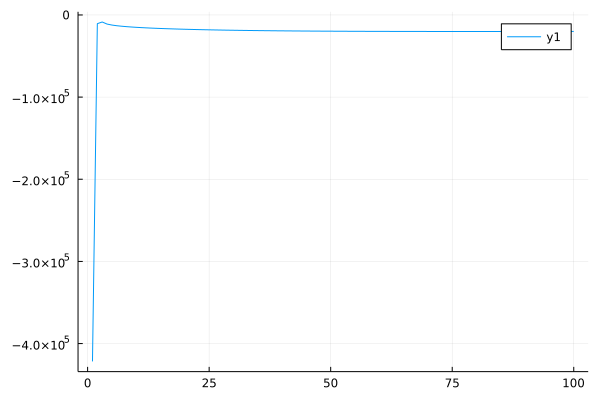

In [83]:
plot(fe)

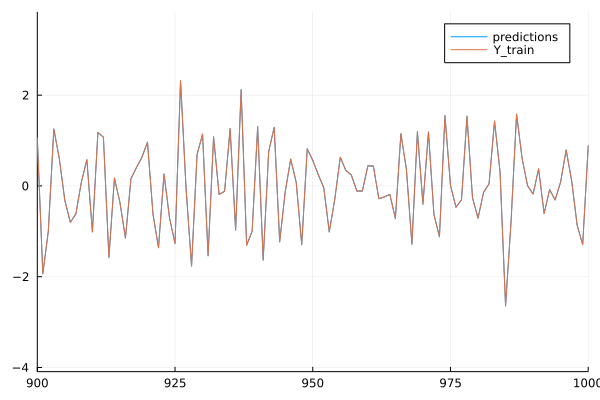

In [84]:
mfrom, mto = 900, 1000
plot(first.(mean.(ẑ)), ribbon=first.(sqrt.(cov.(ẑ))), label="predictions")
plot!(Y_train, xlims=(mfrom, mto), label="Y_train")

In [85]:
mean(w)

9804.420911167985

In [86]:
mean(τ)

114.02954676911952

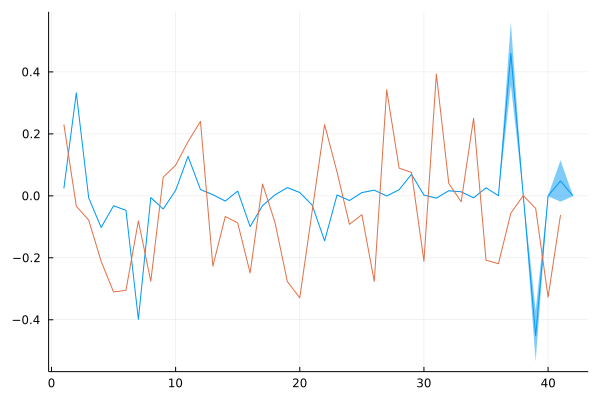

In [87]:
plot(mean(η), ribbon=diag(std(η)), label=false)
plot!(η_true, label=false)

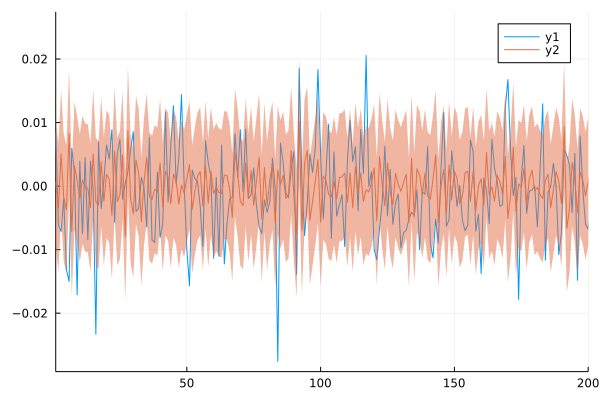

In [88]:
plot(syn_noise)
plot!(first.(mean.(h)), ribbon=sqrt.(first.(cov.(h))), xlims=(1, 200))

## Prediction 

In [89]:
function transition(γ, order)
    V = zeros(order, order)
#     V = diageye(order)
    V[1] = 1/γ
    return V
end

function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [96]:
function prediction(h_prior, w_mle, η_posterior, τ_posterior, y_prev, u; full_order, h_order)
    h_out = @call_rule MvNormalMeanCovariance(:out, Marginalisation) (m_μ=MvNormalMeanPrecision(mean(h_prior), precision(h_prior)), q_Σ=PointMass(transition(mean(w_mle), order_h)))
    ϕ_out = @call_rule NonlinearNode(:out, Marginalisation) (m_in=h_out, meta=NonlinearMeta(phi_, y_prev, u, full_order))
    ar_out = @call_rule AR(:y, Marginalisation) (m_x=ϕ_out, q_θ=η_posterior, q_γ=τ_posterior, meta=ARMeta(Multivariate, full_order, ARsafe()))
    c = zeros(full_order); c[1] = 1.0
    dot_out = @call_rule typeof(dot)(:out, Marginalisation) (m_in1=PointMass(c), m_in2=ar_out, meta=ReactiveMP.TinyCorrection())
    c = zeros(h_order); c[1] = 1.0
    c_out = @call_rule typeof(dot)(:out, Marginalisation) (m_in1=PointMass(c), m_in2=h_out, meta=ReactiveMP.TinyCorrection())
    @call_rule typeof(+)(:out, Marginalisation) (m_in1=dot_out, m_in2=c_out)    
end

prediction (generic function with 1 method)

In [110]:
function inference_callback(h_prior, η_prior, τ_prior, w_prior, Y, X, U, order_h, full_order)
    
    narmax_imarginals = (h = h_prior,
                         w = w_prior,
                         θ = MvNormalMeanPrecision(zeros(order_h), 1e12*diageye(order_h)),
                         τ = τ_prior,
                         η = η_prior);
    
    narmax_imessages = (h = MvNormalMeanPrecision(zeros(order_h), diageye(order_h)), );
    
    narmax_model = Model(narmax, length(Y), 
                    (mean(h_prior), precision(h_prior)), 
                    (shape(w_prior), rate(w_prior)), 
                    (mean(η_prior), precision(η_prior)), 
                    (shape(τ_prior), rate(τ_prior)), 
                    X, U, order_h, full_order);
    
    narmax_imarginals = (h = h_prior,
                         w = w_prior,
                         θ = MvNormalMeanPrecision(zeros(order_h), 1e12*diageye(order_h)),
                         τ = τ_prior,
                         η = η_prior);
    
    res = inference(
                        model = narmax_model, 
                        data  = (y = Y, ),
                        constraints   = narmax_constraints,
                        meta          = narmax_meta(Multivariate, order_h, full_order, ARsafe()),
                        options       = model_options(limit_stack_depth = 500),
                        initmarginals = narmax_imarginals,
                        initmessages  = narmax_imessages,
                        returnvars    = (θ = KeepLast(), w=KeepLast(), h=KeepLast(), η=KeepLast(), τ=KeepLast(), z=KeepLast(), ẑ=KeepLast()),
                        free_energy   = true,
                        iterations    = 10, 
                        showprogress  = true
                    );

    @unpack θ, w, h, η, τ, z, ẑ = res.posteriors
    θ.data, w.data, h[end].data, η.data, τ.data
end

inference_callback (generic function with 2 methods)

In [115]:
predictions = []
h_prior = h[end].data
w_prior = w.data
τ_prior = τ.data
η_prior = η.data

ProgressMeter.@showprogress for i in 1:length(Y_test)
    pred = prediction(h_prior, mean(w_prior), η_prior, τ_prior, X_test[i], U_test[i], full_order=full_order, h_order=order_h)
    push!(predictions, pred)
    θ_post, w_post, h_post, η_post, τ_post = inference_callback(h_prior, η_prior, τ_prior, w_prior, [Y_test[i]], [X_test[i]], [U_test[i]], order_h, full_order)
    h_prior = h_post
    η_prior = η_post
    τ_prior = τ_post
    w_prior = w_post
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:26


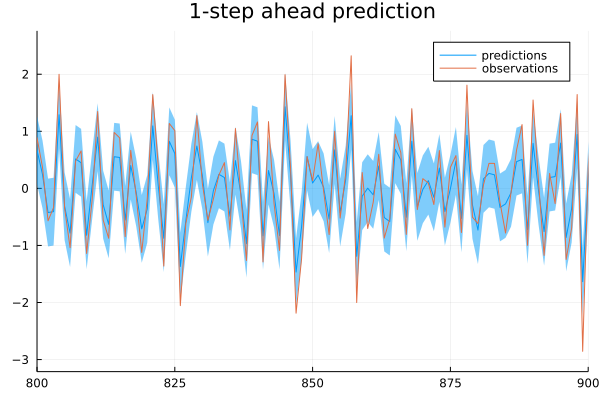

In [120]:
plot(mean.(predictions), ribbon=sqrt.(first.(cov.(predictions))), label="predictions")
plot!(Y_test, xlims=(800, 900), title="1-step ahead prediction", label="observations")

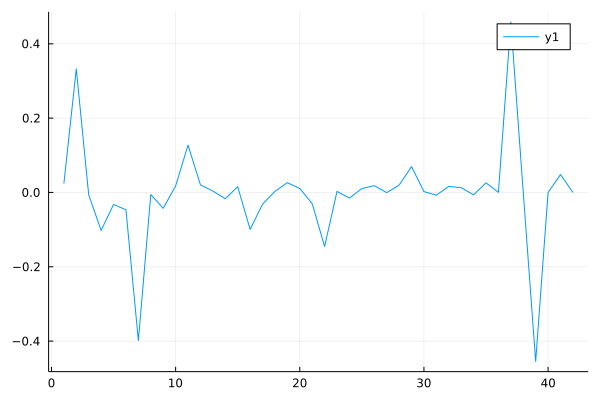

In [117]:
plot(mean(η_prior))

In [118]:
RMSE = sqrt(mean((mean.(predictions) .- Y_test) .^2))

0.38355484156017283

In [119]:
# naive simulation setting

In [122]:
h_prior = h[end].data
w_prior = w.data
τ_prior = τ.data
η_prior = η.data

simulated_X = [X_test[1]]
simulated_Y = [Y_test[1]]
simulated_Y_cov = [0.0]
simulated_error = Vector{Any}([h[end]])

ProgressMeter.@showprogress for i in 1:length(Y_test)
    θ_post, w_post, h_post, η_post, τ_post = inference_callback(h_prior, η_prior, τ_prior, w_prior, [simulated_Y[i]], [simulated_X[i]], [U_test[i]], order_h, full_order)
    
    h_prior = h_post
    η_prior = η_post
    τ_prior = τ_post
    w_prior = w_post
    
    push!(simulated_X, [simulated_Y[i]; simulated_X[i][1:delay_y-1]])
    
    pred_sim = prediction(h_prior, mean(w_prior), η_prior, τ_prior, simulated_X[end], U_test[i], full_order=full_order, h_order=order_h)

    push!(simulated_Y, mean(pred_sim))
    push!(simulated_Y_cov, var(pred_sim))
    push!(simulated_error, h_prior)
    

end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:28


In [123]:
RMSE = sqrt(mean((simulated_Y[2:end] .- Y_test).^2))

0.42129468872742076

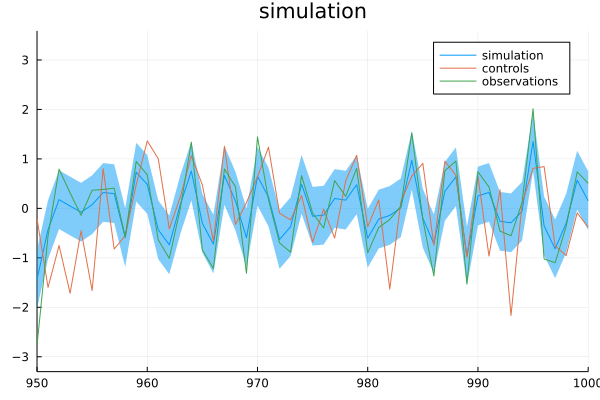

In [128]:
plot(simulated_Y[2:end], ribbon=sqrt.(simulated_Y_cov[2:end]), label="simulation")
plot!(first.(U_test), label="controls")
plot!(Y_test, title="simulation", label="observations", xlims=(950, 1000))

In [132]:
zoom = 1:1000
RMSE = sqrt(mean((simulated_Y[zoom .+ 1] .- Y_test[zoom]).^2))

0.42129468872742076